In [1]:
from flash_attention_torch_vectorized import flash_attn_torch_vectorized_fn
from flash_attention_triton import flash_attn_triton_fn
from flash_attention_triton_numstages import flash_attn_variants
from flash_attention_triton_numwarps import flash_attn_warps_variants
import torch
import triton
import triton.language as tl
import triton.testing as tt
DEIVCE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Triton v.s. Torch.compile fwd

In [2]:


# Triton v.s. Torch
configs_memory = tt.Benchmark(
    x_names=["N"],
    x_vals=[2 ** i for i in range(4, 16)],
    line_arg="provider",
    line_vals=["triton", "torch"],
    line_names=["Triton", "Torch"],
    plot_name="flash-attention-runtime-seqlen",
    args={},
)
@tt.perf_report(configs_memory)
def benchmark_fa_runtime(N, provider):
    device = DEIVCE
    dtype = torch.float32
    
    D = 128
    B = 16
    Q = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=True)
    K = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=True)
    V = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=True)


    ms_min, ms_med, ms_max = tt.do_bench(
        lambda: flash_attn_triton_fn(Q,K,V, True) if provider == "triton"
        else flash_attn_torch_vectorized_fn(Q, K, V, True),
        quantiles=(0.0, 0.5, 1.0),
    )

    return ms_med, ms_min, ms_max


    B = 16
    Q = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=True)
    K = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=True)
    V = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=True)


    ms_min, ms_med, ms_max = tt.do_bench(
        lambda: flash_attn_triton_fn(Q,K,V, True) if provider == "num_stage1"
        else flash_attn_triton_fn(Q, K, V, True),
        quantiles=(0.0, 0.5, 1.0),
    )

    return ms_med, ms_min, ms_max

In [3]:
torch.cuda.empty_cache()
benchmark_fa_runtime.run(save_path='cs336_systems/triton_kernels/benchmarking', print_data=False)
torch.cuda.empty_cache()

/workspace/assignment2-systems-main/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0212 13:09:09.582000 67636 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 GiB. GPU 0 has a total capacity of 11.63 GiB of which 10.99 GiB is free. Process 548837 has 642.00 MiB memory in use. Of the allocated memory 392.12 MiB is allocated by PyTorch, and 119.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Triton numstage

flash-attention-numstages-comparison:
      N  stages=1  stages=2  stages=3
0  16.0  0.014336  0.013312  0.013312
1  32.0  0.015360  0.014336  0.013312
2  64.0  0.016384  0.015360  0.014336


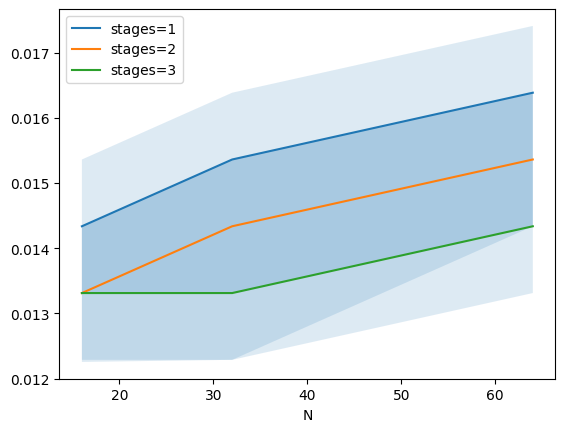

In [ ]:
# ============================================================================
# Benchmark num_stages effect (stages 1-8)
# ============================================================================

configs_numstages = tt.Benchmark(
    x_names=["N"],
    x_vals=[2 ** i for i in range(4, 7)],
    line_arg="num_stages",
    line_vals=list(range(1, 4)), # Change this & the config files
    line_names=[f"stages={i}" for i in range(1, 4)], # Change this & the config files
    plot_name="flash-attention-numstages-comparison",
    args={},
)

@tt.perf_report(configs_numstages)
def benchmark_numstages_effect(N, num_stages):
    """
    Compare Triton kernel performance with different num_stages values (1-8).
    
    num_stages controls the pipeline depth in GPU kernels:
    - Lower (1-2): Less memory usage, potentially higher latency
    - Medium (3-5): Balanced latency hiding and memory
    - Higher (6-8): Better latency hiding, higher memory usage
    
    This benchmark shows the tradeoff for your specific hardware.
    """
    device = DEIVCE
    dtype = torch.float32
    
    D = 64
    B = 16
    Q = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=False)
    K = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=False)
    V = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=False)
    
    # Select the appropriate variant for this num_stages
    kernel_fn = flash_attn_variants[num_stages]
    
    fn = lambda: kernel_fn(Q, K, V, False)
    
    ms_min, ms_med, ms_max = tt.do_bench(fn, quantiles=(0.0, 0.5, 1.0))
    
    return ms_med, ms_min, ms_max

# Run the benchmark
torch.cuda.empty_cache()
benchmark_numstages_effect.run(save_path='cs336_systems/triton_kernels/benchmarking', print_data=True)
torch.cuda.empty_cache()


flash-attention-numwarps-comparison:
      N   warps=1   warps=2   warps=4   warps=8  warps=16
0  16.0  0.040960  0.015360  0.013312  0.014336  0.016384
1  32.0  0.040960  0.015360  0.013312  0.013312  0.016384
2  64.0  0.044032  0.016384  0.013312  0.013312  0.016384


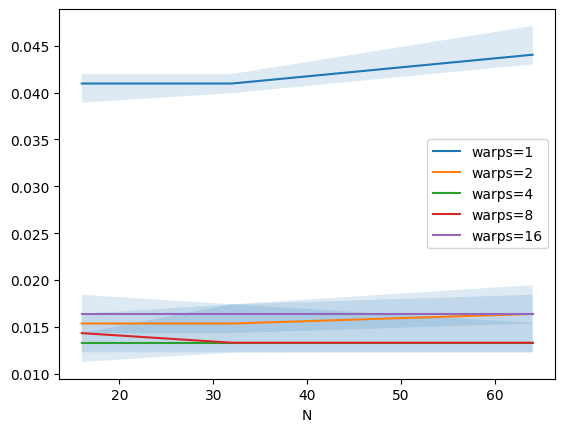

In [ ]:
# ============================================================================
# Benchmark num_warps effect (1, 2, 4, 8, 16)
# ============================================================================

configs_numwarps = tt.Benchmark(
    x_names=["N"],
    x_vals=[2 ** i for i in range(4, 7)],
    line_arg="num_warps",
    line_vals=[1, 2, 4, 8, 16],
    line_names=[f"warps={w}" for w in [1, 2, 4, 8, 16]],
    plot_name="flash-attention-numwarps-comparison",
    args={},
)

@tt.perf_report(configs_numwarps)
def benchmark_numwarps_effect(N, num_warps):
    """
    Compare Triton kernel performance with different num_warps values.
    
    num_warps controls the number of GPU warps (32 threads each) per block:
    - Lower (1-2): Simpler scheduling, lower resource contention
    - Medium (4-8): Standard configurations, good occupancy
    - Higher (16): Maximum occupancy, higher resource usage
    
    Affects: GPU occupancy, shared memory usage, latency hiding capability.
    This benchmark shows the tradeoff for your specific hardware.
    """
    device = DEIVCE
    dtype = torch.float32
    
    D = 64
    B = 16
    Q = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=False)
    K = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=False)
    V = torch.randn((B, N, D), device=device, dtype=dtype, requires_grad=False)
    
    # Select the appropriate variant for this num_warps
    kernel_fn = flash_attn_warps_variants[num_warps]
    
    fn = lambda: kernel_fn(Q, K, V, False)
    
    ms_min, ms_med, ms_max = tt.do_bench(fn, quantiles=(0.0, 0.5, 1.0))
    
    return ms_med, ms_min, ms_max

# Run the benchmark
torch.cuda.empty_cache()
benchmark_numwarps_effect.run(save_path='cs336_systems/triton_kernels/benchmarking', print_data=True)
torch.cuda.empty_cache()
